In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
import time
import pickle
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal as mltnorm
from scipy.sparse import csr_matrix
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
%matplotlib inline

In [3]:
from functions import *

In [4]:
from algorithms_comp import *

In [5]:
%load_ext autoreload

In [6]:
%aimport algorithms_comp
%aimport -algorithms_comp
%aimport algorithms_comp

In [7]:
from utils import *

# Logistic regression

## a9a

In [8]:
%%time
dataset = "phishing"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Number of functions in the sum: ", m, ", dimension of the problem: ", n)
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness constant of the sum: ", L)
print("Average smoothness constant   : ", average_L)
print("Worst smoothness constant     : ", worst_L)
print("Fraction of non-zero elemenst : ", sparsity_A)

Number of functions in the sum:  11055 , dimension of the problem:  68
Smoothness constant of the sum:  0.162551076374935
Average smoothness constant   :  0.24998853674998603
Worst smoothness constant     :  0.24998853675000005
Fraction of non-zero elemenst :  0.4411764705882353
CPU times: total: 328 ms
Wall time: 304 ms


### Find the solution

In [9]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = 0
l1 = 0

In [10]:
%%time
param = [A, y, l2, False]
res_solver = minimize(logreg_loss, x_init, args = param, jac=logreg_grad, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-10)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

True
0.14159664485459114
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.14159664485459114
        x: [-3.568e+00  1.751e+00 ... -2.246e+00  4.901e+00]
      nit: 202
      jac: [ 4.191e-08 -5.799e-09 ...  1.874e-08 -4.808e-08]
     nfev: 233
     njev: 233
 hess_inv: <68x68 LbfgsInvHessProduct with dtype=float64>
CPU times: total: 625 ms
Wall time: 636 ms


In [11]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

# Parameters

In [12]:
l2 = 0
l1 = 0
sparse = False
sparse_full = True


bs = y.shape[0]

x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

num_of_non_zeros = 1
x_init = deepcopy(x_star)
shift_param = 11.0
x_init[0:num_of_non_zeros] += shift_param
N = 100

filename = dataset+"_init_first_"+str(num_of_non_zeros)+"_shift_"+str(shift_param)
delta = 0
t = 0.1
param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]


print("f(x_0)-f(x^*) = ", logreg_loss(x_init, [A, y, l2, False, t]) - f_star)
epsilon = 1e-3

f(x_0)-f(x^*) =  0.024101101592159224


## Tests

In [12]:
N = 100000
step_param = 1
batch_sizes = [10, 100]
overbatching_cnst = 4 * A.shape[1] * (3 * 125)
smoothing_param = 1e-10
delta = 0
print(f'Theoretical overbatching cnst is {overbatching_cnst}')

for bs in batch_sizes:
    theoretical_rho = max(1, overbatching_cnst / bs)
    rhos = [theoretical_rho, theoretical_rho / 10] 
    for rho in rhos:
        args = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, smoothing_param]

        Our_method = ZO_AccSGD(filename, x_init, args=args, bs=bs, N=N,
                                f_star=f_star, x_star=x_star, tuning_stepsize_param=1)
        
        print(f'Finished, params: rho = {rho}')

Theoretical overbatching cnst is 102000
10200.0


100%|██████████| 100000/100000 [09:37<00:00, 173.08it/s]


Finished, params: rho = 10200.0
1020.0


100%|██████████| 100000/100000 [09:28<00:00, 175.96it/s]


Finished, params: rho = 1020.0
1020.0


100%|██████████| 100000/100000 [1:24:57<00:00, 19.62it/s]


Finished, params: rho = 1020.0
102.0


100%|██████████| 100000/100000 [1:25:53<00:00, 19.40it/s]


Finished, params: rho = 102.0


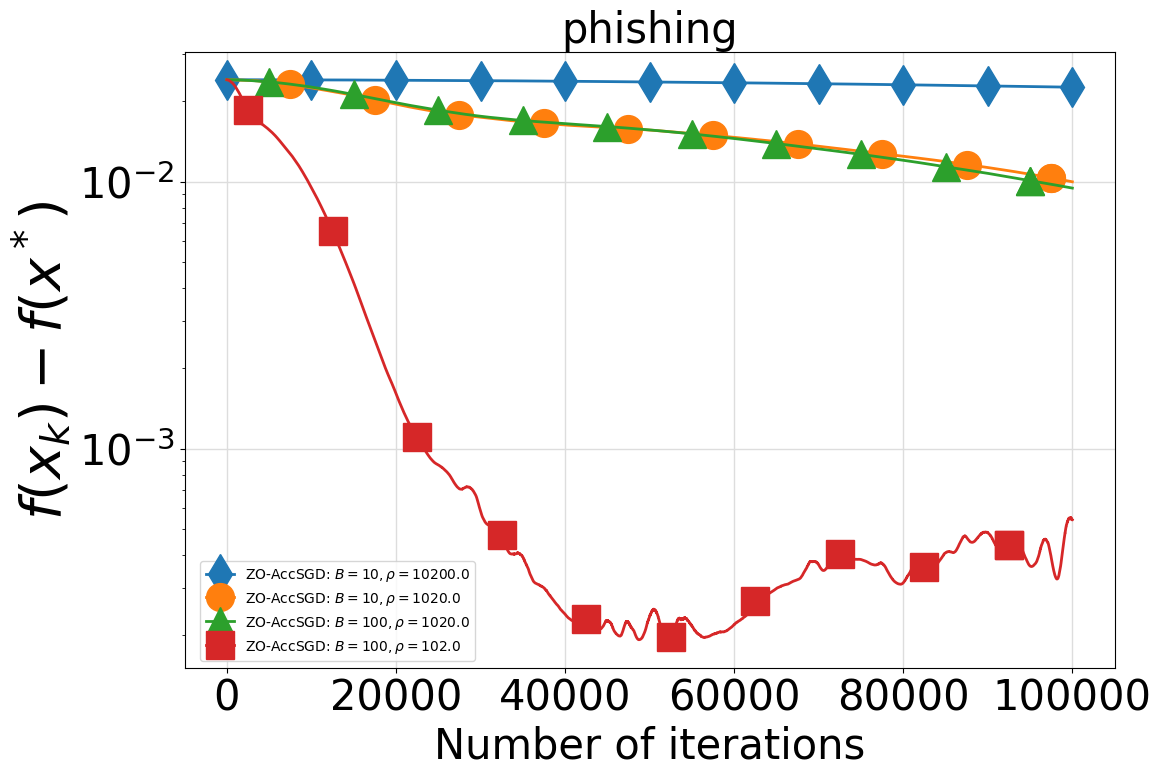

In [13]:
methods = []
N = 100000
step_param = 1
batch_sizes = [10, 100]
overbatching_cnst = 4 * A.shape[1] * (3 * 125)
delta = 0

for bs in batch_sizes:
    theoretical_rho = max(1, overbatching_cnst / bs)
    rhos = [theoretical_rho, theoretical_rho / 10] 
    for rho in rhos:
        methods.append(['Our_algorithm logreg', [step_param, N, delta, bs, rho],
                        fr"ZO-AccSGD: $B = {bs}, \rho = {rho}$", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+"_rho_"+str(rho)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [18]:
%%time
N = 91
stepsizes = [1e-1, 1e1, 1e2, 1e3]
bs = 10
delta = 0

for step_param in stepsizes:
    param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]
    rdfds_e_res = rdfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

100%|██████████| 100600/100600 [00:27<00:00, 3640.45it/s]


Finished with stepsize parameter =  0.1


100%|██████████| 100600/100600 [00:25<00:00, 3927.40it/s]


Finished with stepsize parameter =  10.0


100%|██████████| 100600/100600 [00:25<00:00, 3893.08it/s]


Finished with stepsize parameter =  100.0


100%|██████████| 100600/100600 [00:22<00:00, 4557.75it/s]

Finished with stepsize parameter =  1000.0
CPU times: total: 1min 39s
Wall time: 1min 41s


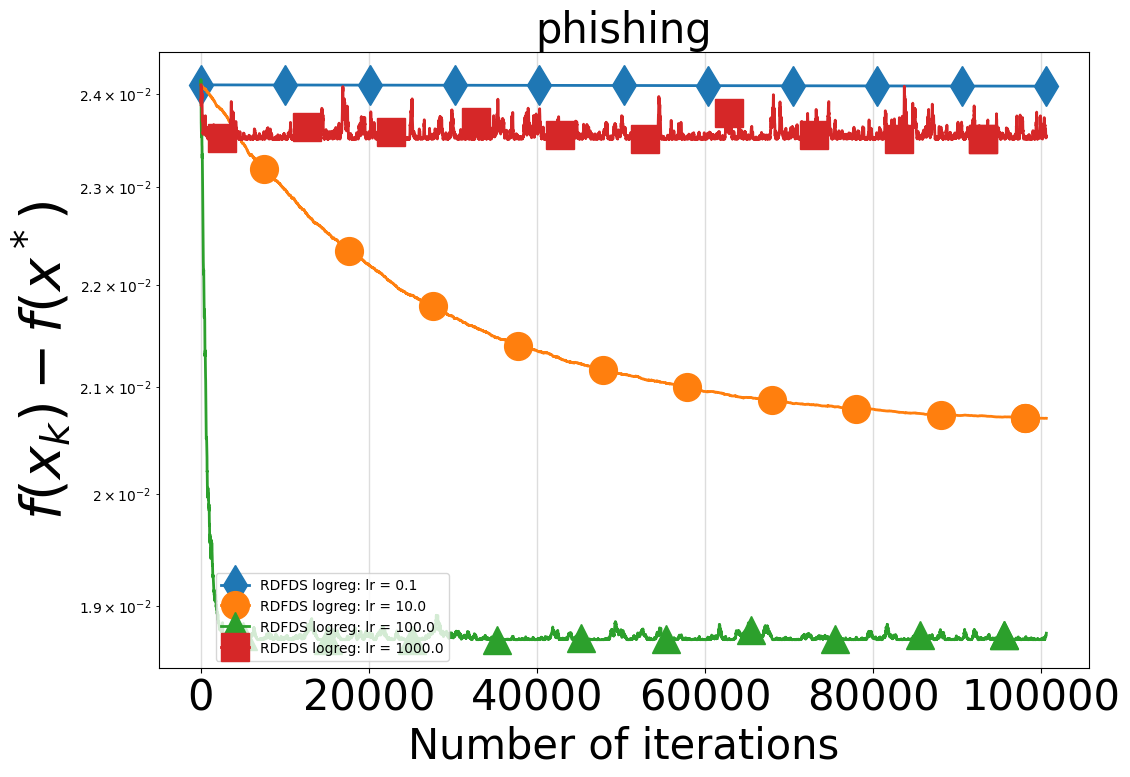

In [19]:
methods = []
N = 91
stepsizes = [1e-1, 1e1, 1e2, 1e3]
bs = 10
delta = 0
for step_param in stepsizes:
    methods.append(['RDFDS_E logreg', [step_param, N, delta, bs],
                        f"RDFDS logreg: lr = {step_param}", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"RDFDS_E_logreg"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [22]:
%%time
N = 91
stepsizes = [1e-2, 1e-3, 1e-4]
bs = 10
delta = 0

for step_param in stepsizes:
    param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]
    ardfds_e_res = ardfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

  0%|          | 0/100600 [00:00<?, ?it/s]

100%|██████████| 100600/100600 [00:25<00:00, 3933.94it/s]


Finished with stepsize parameter =  0.01


100%|██████████| 100600/100600 [00:23<00:00, 4270.41it/s]


Finished with stepsize parameter =  0.001


100%|██████████| 100600/100600 [00:28<00:00, 3471.90it/s]

Finished with stepsize parameter =  0.0001
CPU times: total: 1min 16s
Wall time: 1min 18s


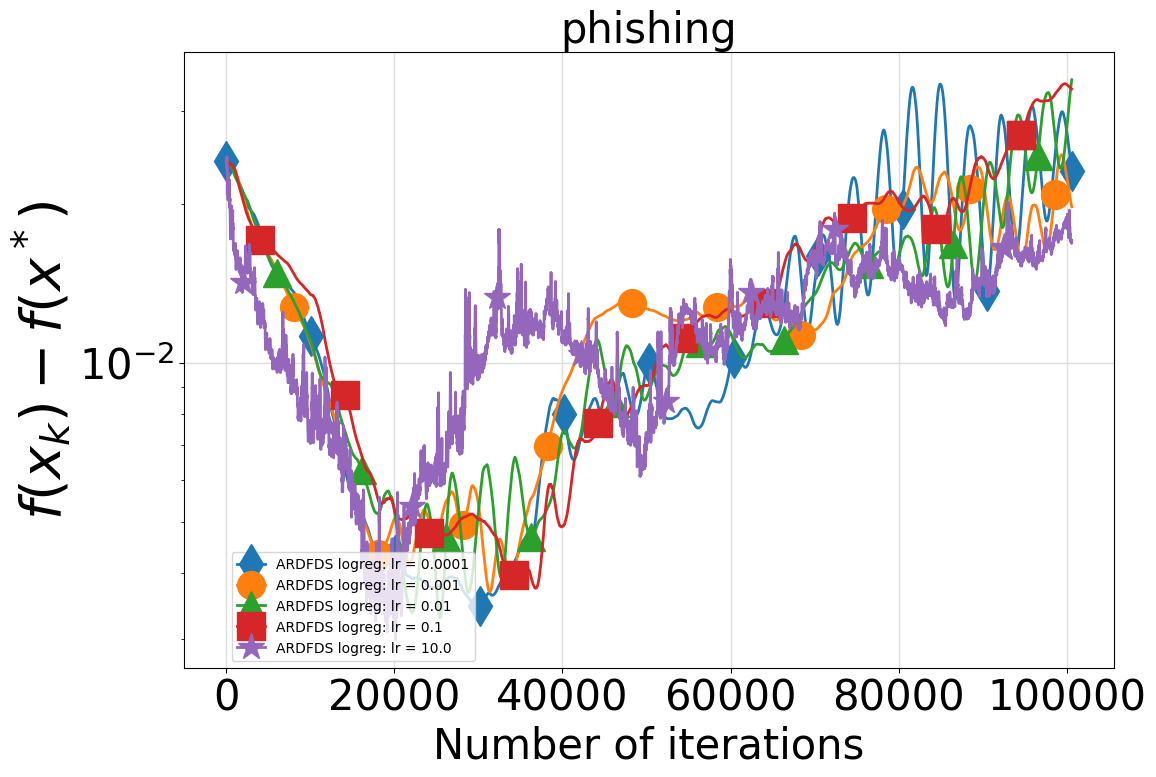

In [24]:
methods = []
N = 91
stepsizes = [1e-4, 1e-3, 1e-2, 1e-1, 1e1]
bs = 10
delta = 0
for step_param in stepsizes:
    methods.append(['ARDFDS_E logreg', [step_param, N, delta, bs],
                        f"ARDFDS logreg: lr = {step_param}", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"ARDFDS_E_logreg"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

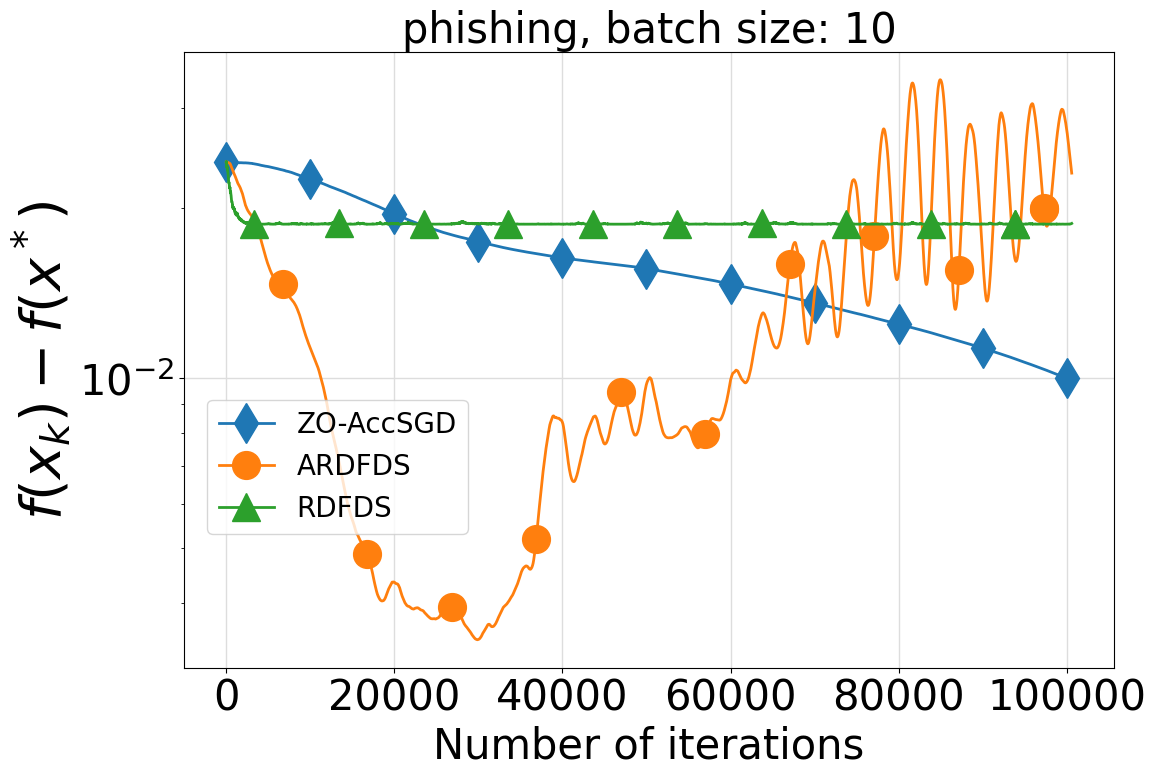

In [41]:
bs = 10
methods = [['Our_algorithm logreg', [1, 100_000, 0, bs, 1020.0], f"ZO-AccSGD", None],
           ['ARDFDS_E logreg', [1e-4, 91, 0, bs], f"ARDFDS", None],
           ['RDFDS_E logreg', [1e2, 91, 0, bs], f"RDFDS", None]]

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = 'phishing, batch size: 10'
bbox_to_anchor = (0.32,0.195)
legend_loc='best'

save_fig = [True, filename+"phishing_comparison_small"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [30]:
%%time
N = 908
stepsizes = [1e-1, 1e1, 1e2, 1e3]
bs = 100
delta = 0

for step_param in stepsizes:
    param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]
    rdfds_e_res = rdfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

100%|██████████| 100379/100379 [00:26<00:00, 3851.76it/s]


Finished with stepsize parameter =  0.1


100%|██████████| 100379/100379 [00:23<00:00, 4216.04it/s]


Finished with stepsize parameter =  10.0


100%|██████████| 100379/100379 [00:25<00:00, 3932.47it/s]


Finished with stepsize parameter =  100.0


100%|██████████| 100379/100379 [00:24<00:00, 4121.29it/s]

Finished with stepsize parameter =  1000.0
CPU times: total: 1min 39s
Wall time: 1min 41s


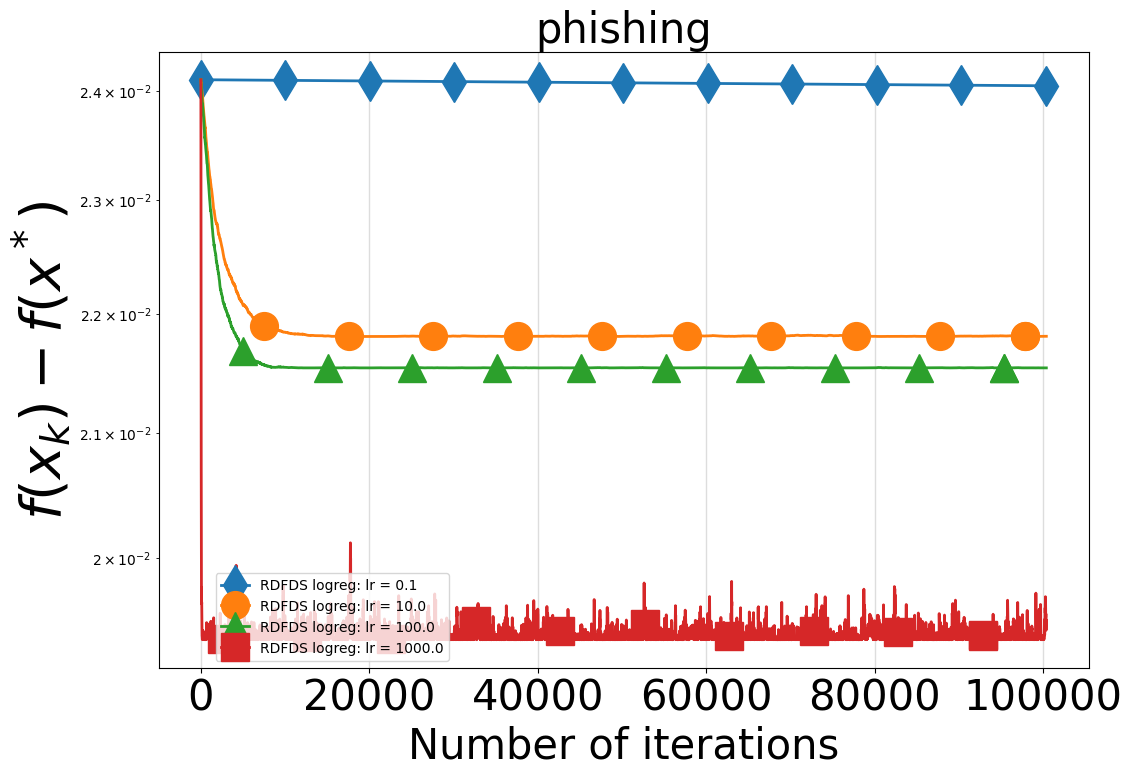

In [31]:
methods = []
N = 908
stepsizes = [1e-1, 1e1, 1e2, 1e3]
bs = 100
delta = 0
for step_param in stepsizes:
    methods.append(['RDFDS_E logreg', [step_param, N, delta, bs],
                        f"RDFDS logreg: lr = {step_param}", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"RDFDS_E_logreg"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [32]:
%%time
N = 908
stepsizes = [1e-2, 1e-3, 1e-4, 1e-1, 1e1]
bs = 100
delta = 0

for step_param in stepsizes:
    param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]
    ardfds_e_res = ardfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
    print("Finished with stepsize parameter = ", step_param)

100%|██████████| 100379/100379 [00:28<00:00, 3533.47it/s]


Finished with stepsize parameter =  0.01


100%|██████████| 100379/100379 [00:29<00:00, 3412.41it/s]


Finished with stepsize parameter =  0.001


100%|██████████| 100379/100379 [00:25<00:00, 3943.34it/s]


Finished with stepsize parameter =  0.0001


100%|██████████| 100379/100379 [00:28<00:00, 3556.89it/s]


Finished with stepsize parameter =  0.1


100%|██████████| 100379/100379 [00:26<00:00, 3732.98it/s]

Finished with stepsize parameter =  10.0
CPU times: total: 2min 16s
Wall time: 2min 18s


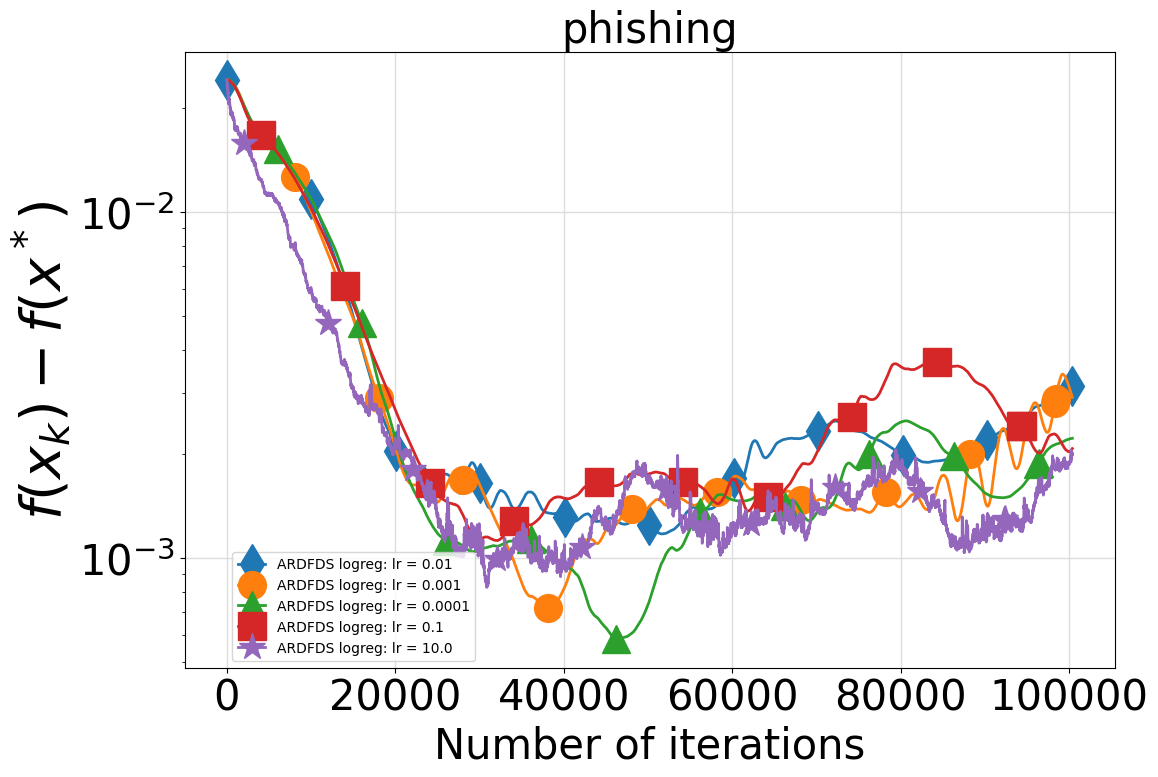

In [33]:
methods = []
N = 908
stepsizes = [1e-2, 1e-3, 1e-4, 1e-1, 1e1]
bs = 100
delta = 0
for step_param in stepsizes:
    methods.append(['ARDFDS_E logreg', [step_param, N, delta, bs],
                        f"ARDFDS logreg: lr = {step_param}", None])

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"ARDFDS_E_logreg"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

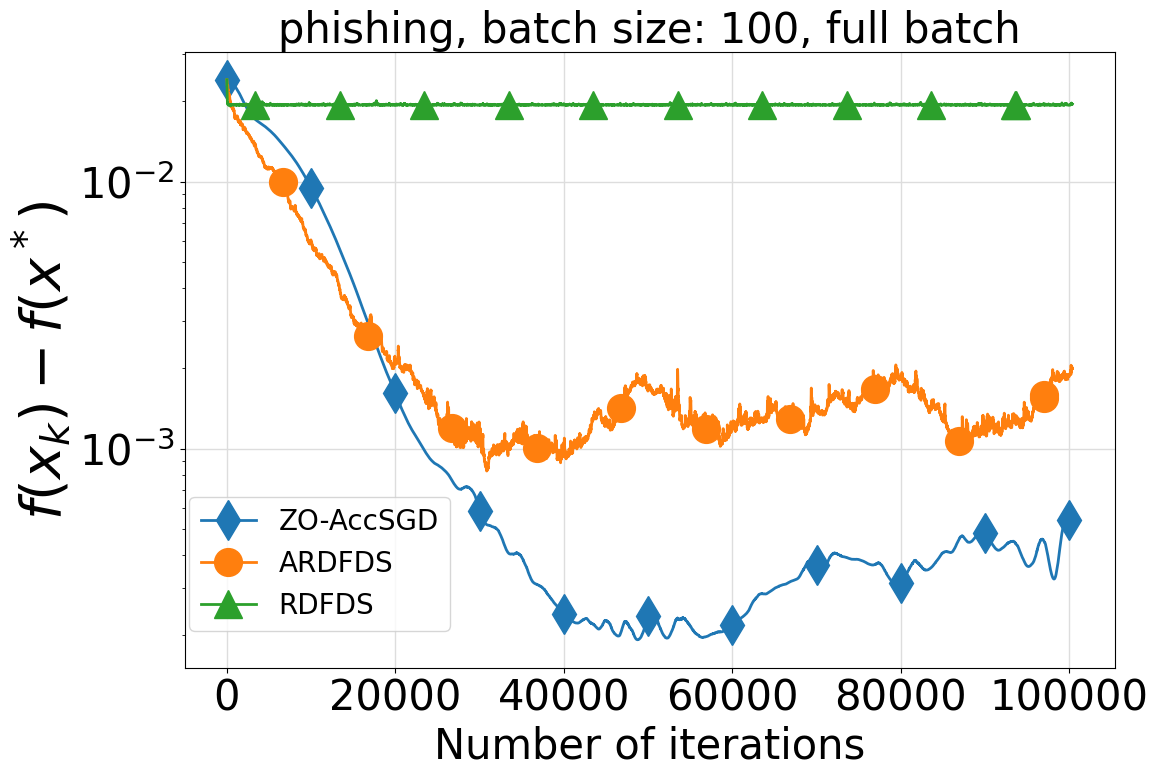

In [37]:
bs = 100
methods = [['Our_algorithm logreg', [1, 100_000, 0, bs, 102.0], f"ZO-AccSGD", None],
           ['ARDFDS_E logreg', [1e1, 908, 0, bs], f"ARDFDS", None],
           ['RDFDS_E logreg', [1e3, 908, 0, bs], f"RDFDS", None]]

mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = 'phishing, batch size: 100'
bbox_to_anchor = (0.3,0.3)
legend_loc='best'

save_fig = [True, filename+"phishing_comparison_small"+"_delta_"+str(delta)
            +"_batch_"+str(bs)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)